#1. Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Import thư viện

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
movies = pd.read_csv('/content/drive/My Drive/ML-Hybrid_RS/Dataset/ml-latest-small/movies.csv')
ratings = pd.read_csv('/content/drive/My Drive/ML-Hybrid_RS/Dataset/ml-latest-small/ratings.csv')

In [ ]:
print("Movies:")
movies.head()

In [ ]:
print("Ratings:")
ratings.head()

In [ ]:
print(f"Movies: {movies.shape}")
print(f"Ratings: {ratings.shape}")

#2. Data describe

In [ ]:
movies.info()

In [ ]:
ratings.info()

In [ ]:
num_users = ratings['userId'].nunique()
print(f"Số lượng người dùng (users) trong DataFrame ratings là: {num_users}")
total_ratings = ratings.shape[0]
avg_rating = ratings['rating'].mean()
print(f"Tổng số đánh giá: {total_ratings}")
print(f"Điểm đánh giá trung bình toàn bộ: {avg_rating:.2f} / 5.0")

Sparsity 98.3% → chỉ 1.7% ma trận có giá trị → rất thưa thớt, phù hợp với thực tế (người dùng chỉ xem ~1–2% tổng phim).

In [ ]:
n_ratings = ratings.shape[0]
n_users = ratings['userId'].nunique()
n_movies = movies['movieId'].nunique()

sparsity = 1 - n_ratings / (n_users * n_movies)
print(f" Sparsity: {sparsity*100:.2f}%")


sparsity = 1 - n_ratings / (n_users * n_movies)
print(f" Sparsity: {sparsity*100:.2f}%")

Phân bố lệch phải mạnh → ít người dùng tích cực, nhiều người dùng ít hoạt động

In [ ]:
user_counts = ratings.groupby('userId').size()

plt.figure(figsize=(6,4))
sns.histplot(user_counts, bins=30)
plt.title("Rating Count per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Users")
plt.show()

print("User activity summary:\n", user_counts.describe())

In [ ]:
user_counts = ratings['userId'].value_counts()

# Top 10 user có số rating nhiều nhất
print("\nTop 10 users có nhiều rating nhất:")
print(user_counts.head(10))

In [ ]:
ratings['rating'].describe()

Phân phối điểm đánh giá (rating)

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=ratings)
plt.title('Phân phối Điểm đánh giá (Ratings Distribution) ')
plt.xlabel('Điểm đánh giá (Rating)')
plt.ylabel('Số lượng')
plt.show()

Kiểm tra rỗng

In [ ]:
movies.isnull().sum()

In [ ]:
ratings.isnull().sum()

Top phim phổ biến

In [ ]:
movies['genres'] = movies['genres'].str.split('|')
genre_exploded = movies.explode('genres')

plt.figure(figsize=(8,5))
genre_exploded['genres'].value_counts().plot(kind='bar')
plt.title("Number of Movies by Genre")
plt.ylabel("Movies")
plt.show()

Average Rating by genres

In [ ]:
ratings_movies = ratings.merge(genre_exploded, on="movieId")

avg_genre_rating = ratings_movies.groupby("genres")['rating'].mean().sort_values()

plt.figure(figsize=(8,5))
avg_genre_rating.plot(kind='bar')
plt.title("Average Rating by Genre")
plt.ylabel("Average Rating")
plt.show()


#3. Data Processing

In [ ]:
# --- Xóa timestamp ---
ratings = ratings.drop('timestamp', axis=1)

In [ ]:
min_user_ratings = 30
min_movie_ratings = 20

# --- Lọc tuần tự ---
# 1. Lọc user có ≥ 30 ratings
active_users = ratings['userId'].value_counts()
active_users = active_users[active_users >= min_user_ratings].index
ratings = ratings[ratings['userId'].isin(active_users)]

# 2. Lọc phim có ≥ 20 ratings
popular_movies = ratings['movieId'].value_counts()
popular_movies = popular_movies[popular_movies >= min_movie_ratings].index
ratings = ratings[ratings['movieId'].isin(popular_movies)]

# 3. LỌC LẠI USER (vì có thể mất rating sau khi bỏ phim)
final_active_users = ratings['userId'].value_counts()
final_active_users = final_active_users[final_active_users >= min_user_ratings].index
ratings = ratings[ratings['userId'].isin(final_active_users)]

# --- In kết quả ---
print(f"Users sau lọc cuối: {len(final_active_users)}")
print(f"Movies sau lọc: {len(popular_movies)}")
print(f"Số rating còn lại: {len(ratings)}")

In [ ]:
# Tạo genres dummies (content-based features, từ Paper 1)
genres_dummies = movies['genres'].str.get_dummies(sep='|')
movies_genres = pd.concat([movies[['movieId']], genres_dummies], axis=1)

# Merge ratings với genres để biết user đã xem phim thể loại nào
ratings_with_genres = ratings.merge(movies_genres, on='movieId', how='left')

In [ ]:
ratings_with_genres.head()

## CB

Hiện tại bạn đang lấy trung bình “1” và “0” cho mỗi thể loại → tương ứng với tỷ lệ xem phim thể loại đó (weighted equally).
➡️ Tuy nhiên, nếu bạn muốn thể hiện sở thích mạnh/yếu hơn, có thể dùng trung bình có trọng số rating,

In [ ]:
# TẠO USER-GENRE PROFILE
# Tạo user_genre_pref: trung bình rating theo thể loại (cân bằng theo rating)
user_genre_pref = ratings_with_genres.groupby('userId').apply(
    lambda x: pd.Series(
        np.average(x[genres_dummies.columns], axis=0, weights=x['rating']),
        index=genres_dummies.columns
    )
).reindex(final_active_users).fillna(0)  #reindex đúng user

In [ ]:
print(f"user_genre_pref shape: {user_genre_pref.shape}")

In [ ]:
user_genre_pref.head()

## User-based CF

In [ ]:
# Ma trận R
R = ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

# Z-score normalize (loại bias user)
R_normalized = R.apply(lambda x: (x - x.mean()) / (x.std() + 1e-9), axis=1).fillna(0)

In [ ]:
R.head()

In [ ]:
R_normalized.head()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# TẠO ĐẶC TRƯNG HYBRID (User profile + Content profile)
hybrid_features = pd.concat([R_normalized, user_genre_pref], axis=1).fillna(0)
hybrid_features.columns = hybrid_features.columns.astype(str)

scaler = MinMaxScaler()
hybrid_scaled = pd.DataFrame(
    scaler.fit_transform(hybrid_features),
    index=final_active_users,  # ĐÚNG INDEX
    columns=hybrid_features.columns
)

In [ ]:
hybrid_scaled.head()

## KMeans

dò “Elbow Method” hoặc “Silhouette Score” để chọn K tối ưu

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

hybrid_features.columns = hybrid_features.columns.astype(str)

KMeans yêu cầu tên cột là chuỗi (tránh lỗi khi có tên số hoặc float từ movieId).

In [ ]:
wcss = []

for k in range(2, 13):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(hybrid_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(2, 13), wcss, marker='o', linestyle='--', color='royalblue')
plt.title('Elbow Method – Ước lượng vùng K hợp lý')
plt.xlabel('Số cụm (K)')
plt.ylabel('Tổng WCSS')
plt.grid(True)
plt.show()

In [ ]:
silhouette_scores = []
K_range = range(4, 7)  # vùng K lấy từ kết quả Elbow (3–8 là ví dụ)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(hybrid_scaled)
    score = silhouette_score(hybrid_scaled, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.4f}")

plt.figure(figsize=(8,5))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='--', color='green')
plt.title('Silhouette Score – Xác định K tối ưu')
plt.xlabel('Số cụm (K)')
plt.ylabel('Giá trị Silhouette trung bình')
plt.grid(True)
plt.show()

In [ ]:
# ÁP DỤNG K TỐI ƯU SAU KHI CHỌN
K_opt = K_range[silhouette_scores.index(max(silhouette_scores))]  # chọn K có điểm cao nhất
print(f"🎯 K tối ưu được chọn: {K_opt}")

kmeans_final = KMeans(n_clusters=K_opt, random_state=42, n_init=10)
kmeans_final.fit(hybrid_scaled)

user_clusters = pd.Series(
    kmeans_final.labels_,
    index=hybrid_scaled.index,  # = final_active_users
    name='Cluster'
)

print(user_clusters.value_counts())

## Tính Similarity

Nếu đã chuẩn hóa từng user (R_normalized = (R - mean) / std), thì dùng cosine lúc này chính là Adjusted Cosine rồi! Nếu đã chuẩn hóa trước, cosine_similarity = adjusted cosine.

Nếu R_normalized → cosine_similarity = adjusted cosine ✅

Nếu R gốc chưa chuẩn hóa → dùng Pearson similarity 🔥

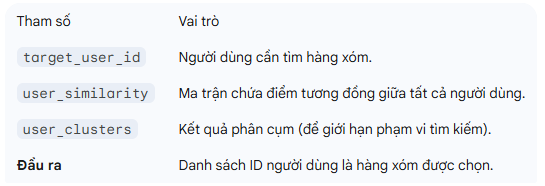

In [ ]:
import numpy as np
import pandas as pd

def cluster_adjusted_cosine(R, user_clusters, min_common_items=50):
    """
    Tính Adjusted Cosine Similarity trong cụm
    - Không lỗi khi rating hằng số
    - Chỉ cần ≥ min_common_items phim chung
    """
    sim_matrix = pd.DataFrame(0.0, index=R.index, columns=R.index)
    item_means = R.mean(axis=0)  # trung bình rating của từng phim

    for c in user_clusters.unique():
        users_in_c = user_clusters[user_clusters == c].index
        if len(users_in_c) <= 1:
            continue

        for i, u1 in enumerate(users_in_c):
            for u2 in users_in_c[i+1:]:
                # Tìm phim chung
                common_items = R.columns[(R.loc[u1] > 0) & (R.loc[u2] > 0)]
                if len(common_items) < min_common_items:
                    continue

                # Adjusted Cosine: trừ đi item mean
                r1 = R.loc[u1, common_items] - item_means[common_items]
                r2 = R.loc[u2, common_items] - item_means[common_items]

                # Tính similarity
                num = (r1 * r2).sum()
                den = np.sqrt((r1**2).sum()) * np.sqrt((r2**2).sum())

                sim = num / den if den > 0 else 0
                sim = max(sim, 0)  # chỉ lấy similarity dương

                sim_matrix.loc[u1, u2] = sim
                sim_matrix.loc[u2, u1] = sim

    return sim_matrix

In [ ]:
user_similarity = cluster_adjusted_cosine(R, user_clusters, min_common_items=2)

print("Similarity trung bình trong cụm:")
for c in user_clusters.unique():
    users_in_c = user_clusters[user_clusters == c].index
    sub = user_similarity.loc[users_in_c, users_in_c]
    # Bỏ đường chéo
    off_diag = sub.values[np.triu_indices_from(sub, k=1)]
    avg = off_diag.mean() if len(off_diag) > 0 else 0
    print(f"  Cụm {c}: {avg:.4f} (users: {len(users_in_c)})")

In [ ]:
user_similarity.head()

## KNN

K-Means: phân cụm users dựa trên vector rating đã chuẩn hóa.
Similarity: phải tính trong cụm bằng adjusted cosine / Pearson.
KNN: chạy trên ma trận similarity, không dùng NearestNeighbors trực tiếp.

In [ ]:
def get_knn_neighbors(user_id, user_similarity, user_clusters, K=20, min_sim=0.3):
    """
    Lấy K neighbors trong cùng cụm, có similarity >= min_sim
    """
    if user_id not in user_clusters.index:
        return pd.Series()

    cluster = user_clusters.loc[user_id]
    users_in_cluster = user_clusters[user_clusters == cluster].index
    users_in_cluster = users_in_cluster.drop(user_id, errors='ignore')

    # Lấy similarity của user_id với tất cả users trong cụm
    sims = user_similarity.loc[user_id, users_in_cluster]
    sims = sims[sims >= min_sim]  # lọc ngưỡng
    sims = sims.sort_values(ascending=False)

    return sims.head(K)  # top K

In [ ]:
# Kiểm tra neighbors của user 42
neighbors = get_knn_neighbors(42, user_similarity, user_clusters, K=10, min_sim=0.3)
print("Top 10 neighbors của user 42:")
for uid, sim in neighbors.items():
    print(f"  User {int(uid)}: {sim:.4f}")

In [ ]:
neighbors.head()

# CF+CB Hybrid Model

In [ ]:
from collections import defaultdict


In [ ]:
ratings_df = ratings
movies_df = movies
user_similarity_df = user_similarity
user_clusters_df = user_clusters

In [ ]:
# Tính toán trước điểm rating trung bình của mỗi user
user_avg_ratings = ratings_df.groupby('userId')['rating'].mean()
user_avg_ratings.head()

In [ ]:
# Tạo một map các phim mà user đã xem để lọc (dạng set để tra cứu nhanh)
user_rated_movies = ratings_df.groupby('userId')['movieId'].apply(set)
print(f"Đã tạo map phim đã xem cho {len(user_rated_movies)} users.")

In [ ]:
# Tạo map thể loại cho phim để tra cứu nhanh
# Đảm bảo cột 'genres' tồn tại
# Tạo map thể loại cho phim
if 'genres' in movies_df.columns:
    movies_df['genres_list'] = movies_df['genres'].apply(
        lambda x: x if isinstance(x, list) else []  # đảm bảo luôn là list
    )
    movie_genre_map = movies_df.set_index('movieId')['genres_list'].to_dict()
    print(f"Đã tạo map thể loại cho {len(movie_genre_map)} phim.")
else:
    print("LỖI: Không tìm thấy cột 'genres' trong dataframe 'movies'.")
    movie_genre_map = {}

In [ ]:
def predict_rating(target_user_id, movie_id, neighbors, user_similarity_df, ratings_df, user_avg_ratings):
    """
    Dự đoán điểm cho 1 user và 1 movie_id cụ thể bằng Weighted Average
    (Sử dụng công thức Weighted Average Deviation from Mean như code tham khảo)
    """
    # Lấy điểm trung bình của user mục tiêu
    target_user_avg = user_avg_ratings.get(target_user_id, 2.5) # Dùng 2.5 nếu user mới

    numerator = 0
    denominator = 0

    # Lấy index (IDs) của các neighbors
    neighbor_ids = neighbors.index

    for neighbor_id in neighbor_ids:
        # Lấy độ tương đồng
        similarity = neighbors.loc[neighbor_id]

        # Bỏ qua nếu độ tương đồng <= 0 (dù hàm get_knn_neighbors đã lọc)
        if similarity <= 0:
            continue

        # Kiểm tra xem hàng xóm này đã rate phim 'movie_id' chưa
        neighbor_ratings = ratings_df[ratings_df['userId'] == neighbor_id]
        movie_rating = neighbor_ratings[neighbor_ratings['movieId'] == movie_id]['rating']

        if not movie_rating.empty:
            # Lấy rating thực tế của hàng xóm
            r_vi = movie_rating.iloc[0]
            # Lấy rating trung bình của hàng xóm
            neighbor_avg = user_avg_ratings.get(neighbor_id, 2.5) # Dùng 2.5 nếu user mới

            # Tính tử số và mẫu số của công thức
            numerator += similarity * (r_vi - neighbor_avg)
            denominator += abs(similarity)

    # Tránh chia cho 0
    if denominator == 0:
        # Nếu không có hàng xóm nào rate phim này, trả về điểm tb của user
        return target_user_avg

    # Công thức dự đoán: avg_user + weighted_avg_deviation
    prediction = target_user_avg + (numerator / denominator)

    # Giới hạn điểm dự đoán trong khoảng (0.5, 5)
    return min(max(prediction, 0.5), 5)

In [ ]:


def _get_candidate_movies(target_user_id, neighbor_ids, ratings_df, user_rated_movies):
    """
    Lấy danh sách các phim mà hàng xóm đã xem
    nhưng user mục tiêu chưa xem.

    Args:
        target_user_id (int): User mục tiêu
        neighbor_ids (pd.Index): Danh sách (Index) ID của các hàng xóm
        ratings_df (pd.DataFrame): Bảng ratings
        user_rated_movies (dict): Map các phim user đã xem
    """


    if len(neighbor_ids) == 0:
        return []

    neighbors_ratings = ratings_df[ratings_df['userId'].isin(neighbor_ids)]
    movies_seen_by_neighbors = set(neighbors_ratings['movieId'])

    movies_seen_by_user = user_rated_movies.get(target_user_id, set())

    movies_to_predict = list(movies_seen_by_neighbors - movies_seen_by_user)

    print(f"Tìm thấy {len(movies_to_predict)} phim ứng cử viên từ hàng xóm.")
    return movies_to_predict

In [ ]:
# --- Tạo Hồ sơ nội dung người dùng (User Content Profile) ---

#Trả về khoảng từ 0-5 -> khác biệt với user_genre_pref

def _get_user_content_profile(target_user_id, ratings_df, movie_genre_map):
    """
    Tạo hồ sơ thể loại của user dựa trên ĐIỂM RATING TRUNG BÌNH.
    Trả về một dict: {'Genre': avg_rating, ...} (Thang điểm 0-5)
    """
    user_ratings = ratings_df[ratings_df['userId'] == target_user_id]

    if user_ratings.empty:
        return {} # Trả về profile rỗng nếu user chưa rate phim nào

    # 1. Thu thập tất cả ratings cho từng thể loại
    genre_ratings_lists = defaultdict(list)
    for _, row in user_ratings.iterrows():
        movie_id = row['movieId']
        rating = row['rating']
        genres = movie_genre_map.get(movie_id, [])
        for genre in genres:
            genre_ratings_lists[genre].append(rating)

    # 2. Tính trung bình cho từng thể loại
    avg_genre_profile = {}
    for genre, ratings_list in genre_ratings_lists.items():
        if ratings_list: # Tránh chia cho 0
            avg_genre_profile[genre] = sum(ratings_list) / len(ratings_list)

    return avg_genre_profile

In [ ]:
# --- Tính điểm nội dung (Content Score) ---

def _get_content_score(movie_id, user_genre_profile, movie_genre_map):
    """
    Tính điểm nội dung cho một phim, dựa trên hồ sơ rating trung bình của user.
    Điểm số sẽ nằm trên cùng thang điểm 0-5.
    """
    movie_genres = movie_genre_map.get(movie_id, [])
    scores = []

    for genre in movie_genres:
        if genre in user_genre_profile:
            # Lấy điểm trung bình user đã rate cho thể loại này
            scores.append(user_genre_profile[genre])

    if not scores:
        # Nếu không có thể loại nào khớp, trả về điểm trung bình (2.5)
        return 2.5

    # Trả về điểm trung bình của các thể loại trong phim
    return sum(scores) / len(scores)

In [ ]:
# --- Tính toán và Sắp xếp lai (Hybrid Calculation & Sorting) ---

def _calculate_recommendation_scores(
    target_user_id,
    movies_to_predict,
    neighbors,
    user_genre_profile,
    user_similarity_df,
    ratings_df,
    user_avg_ratings,
    movie_genre_map
):
    """
    Tính điểm 'predicted_rating' (CF) và 'content_score' (CB)
    cho mỗi phim ứng cử viên.
    """
    results = []

    # Giới hạn số lượng phim cần dự đoán
    if len(movies_to_predict) > 500:
      movies_to_predict = movies_to_predict[:500]


    for movie_id in movies_to_predict:
        # 1. Tính điểm Collaborative Filtering
        pred_rating = predict_rating(
            target_user_id, movie_id, neighbors,
            user_similarity_df, ratings_df, user_avg_ratings
        )

        # 2. Tính điểm Content-Based
        content_score = _get_content_score(movie_id, user_genre_profile, movie_genre_map)

        results.append({
            'movieId': movie_id,
            'predicted_rating': pred_rating,
            'content_score': content_score
        })
    print(f"Đã tính xong 2 loại điểm cho {len(results)} phim.")
    return results

In [ ]:
def _combine_and_sort_scores(results, alpha, beta):
    """
    Kết hợp 2 loại điểm thành 'final_hybrid_score' và sắp xếp.
    """
    if not results:
        return []

    for r in results:
        r['final_hybrid_score'] = (alpha * r['predicted_rating']) + (beta * r['content_score'])

    results.sort(key=lambda x: x['final_hybrid_score'], reverse=True)
    return results

In [ ]:
def _format_top_n_results(sorted_results, top_N, movies_df):
    """
    Lấy Top N kết quả và thêm thông tin phim (title, genres)
    """
    top_n_results = sorted_results[:top_N]

    movie_ids_top_n = [r['movieId'] for r in top_n_results]

    # Lấy thông tin phim từ 'movies_df'
    movie_info = movies_df[movies_df['movieId'].isin(movie_ids_top_n)].set_index('movieId')

    final_output = []
    for r in top_n_results:
        movie_id = r['movieId']
        try:
            # Dùng .loc[movie_id] để tra cứu thông tin
            info = movie_info.loc[movie_id]
            r['title'] = info['title']
            r['genres'] = info['genres']
            final_output.append(r)
        except KeyError:
            # Bỏ qua nếu không tìm thấy thông tin phim (hiếm khi xảy ra)
            print(f"Cảnh báo: Không tìm thấy thông tin cho movieId {movie_id}")
            continue

    if not final_output:
        return pd.DataFrame(columns=['movieId', 'predicted_rating', 'content_score',
                                     'final_hybrid_score', 'title', 'genres'])

    return pd.DataFrame(final_output)

In [ ]:
def _get_top_m_cf_candidates(
    target_user_id,
    movies_to_predict,
    top_M_cf,
    neighbors,
    user_similarity_df,
    ratings_df,
    user_avg_ratings
):
    """
    Tính điểm CF cho tất cả ứng cử viên
    và lọc lấy Top M (top_M_cf) phim tốt nhất.
    """
    cf_results = []
    for movie_id in movies_to_predict:
        pred_rating = predict_rating(
            target_user_id, movie_id, neighbors,
            user_similarity_df, ratings_df, user_avg_ratings
        )
        cf_results.append({
            'movieId': movie_id,
            'predicted_rating': pred_rating
        })

    # Sắp xếp theo 'predicted_rating'
    cf_results.sort(key=lambda x: x['predicted_rating'], reverse=True)

    # Lấy top M (top_M_cf)
    top_m_candidates = cf_results[:top_M_cf]

    print(f"Đã lọc ra Top {len(top_m_candidates)} (tối đa {top_M_cf}) phim có điểm CF cao nhất ---")

    return top_m_candidates

In [ ]:
def get_hybrid_recommendations(
    target_user_id,
    K,                          # Số hàng xóm
    top_N,                      # Số phim gợi ý CUỐI CÙNG
    top_M_cf,                   # Số phim lấy từ CF
    user_similarity_df,
    user_clusters_df,
    ratings_df,
    movies_df,
    user_avg_ratings,
    user_rated_movies,
    movie_genre_map,
    get_knn_neighbors_func,
    alpha=0.4,
    min_sim=0.3
):
    """
    Hàm chính để lấy Top N gợi ý lai, KẾT HỢP THEO KIỂU LỌC (CASCADE).
    """
    beta = 1.0 - alpha

    # === 1. Lấy hàng xóm ===
    print(f"\n--- Tìm {K} hàng xóm (KNN) ---")
    neighbors = get_knn_neighbors_func(
        target_user_id, user_similarity_df, user_clusters_df, K, min_sim
    )
    if neighbors.empty:
        print(f"Không tìm thấy hàng xóm nào cho user {target_user_id} với min_sim={min_sim}.")
        return pd.DataFrame(), {}

    print(f"Tìm thấy {len(neighbors)} hàng xóm: {list(neighbors.index)}")

    # === 2. Tạo hồ sơ Content-based ===
    print(f"Tạo hồ sơ thể loại (Content Profile) ---")
    user_genre_profile = _get_user_content_profile(
        target_user_id, ratings_df, movie_genre_map
    )
    if not user_genre_profile:
        print(f"User {target_user_id} chưa đánh giá phim nào, hồ sơ thể loại rỗng.")
    else:
        print(f"Đã tạo hồ sơ cho {len(user_genre_profile)} thể loại.")

    # === 3. Lấy danh sách phim ứng cử viên ===
    print(f"\n--- Lấy phim ứng cử viên ---")
    movies_to_predict = _get_candidate_movies(
        target_user_id, neighbors.index, ratings_df, user_rated_movies
    )
    if not movies_to_predict:
        print(f"Không tìm thấy phim mới từ hàng xóm cho user {target_user_id}.")
        return pd.DataFrame(), user_genre_profile
    print(f"Tìm thấy {len(movies_to_predict)} phim ứng cử viên thô.")

    # === 4. TÍNH ĐIỂM CF VÀ LỌC TOP-M ===
    top_m_candidates = _get_top_m_cf_candidates(
        target_user_id, movies_to_predict, top_M_cf, neighbors,
        user_similarity_df, ratings_df, user_avg_ratings
    )

    if not top_m_candidates:
        print("Không có ứng cử viên nào sau khi tính và lọc CF.")
        return pd.DataFrame(), user_genre_profile

    # === 5. TÍNH ĐIỂM CB CHO TOP-M ===
    print(f"\n---Tính điểm CB (Content) cho {len(top_m_candidates)} phim ---")

    hybrid_results = []
    for r in top_m_candidates:
        movie_id = r['movieId']
        content_score = _get_content_score(movie_id, user_genre_profile, movie_genre_map)

        hybrid_results.append({
            'movieId': movie_id,
            'predicted_rating': r['predicted_rating'], # Lấy điểm CF đã tính
            'content_score': content_score
        })

    # === 6. KẾT HỢP ĐIỂM VÀ SẮP XẾP ===
    print(f"\n--- Bước 8: Kết hợp điểm (alpha={alpha}) và sắp xếp Top {len(hybrid_results)} ---")
    sorted_results = _combine_and_sort_scores(hybrid_results, alpha, beta)

    # === 7. Format và trả về kết quả Top N ===
    final_recommendations = _format_top_n_results(sorted_results, top_N, movies_df)

    return final_recommendations, user_genre_profile

In [ ]:
# --- Thiết lập thông số ---
target_user = 10
K_neighbors = 40
TOP_M_CF = 150
N_recommendations = 20
ALPHA = 0.4
MIN_SIM = 0.3

print("="*50)
print(f"BẮT ĐẦU QUÁ TRÌNH GỢI Ý CHO USER: {target_user}")
print("="*50)

# --- 1. In các phim user ĐÃ XEM ---
print(f"\n🎬 CÁC PHIM USER {target_user} ĐÃ ĐÁNH GIÁ:")
try:
    user_ratings_history = ratings_df[ratings_df['userId'] == target_user]
    if user_ratings_history.empty:
          print(f"Không tìm thấy đánh giá nào cho user {target_user}.")
    else:
          user_movies_history = user_ratings_history.merge(movies_df, on='movieId')[['title', 'rating', 'genres']]
          print(user_movies_history.to_string(index=False))
except Exception as e:
    print(f"Không tìm thấy đánh giá nào cho user {target_user}. Lỗi: {e}")


# --- 2. Chạy hàm gợi ý chính ---
print(f"\n🚀 ĐANG TÍNH TOÁN GỢI Ý (K={K_neighbors}, Top-M={TOP_M_CF}, Top-N={N_recommendations}, alpha={ALPHA})...")

recommendations, profile = get_hybrid_recommendations(
    target_user_id=target_user,
    K=K_neighbors,
    top_N=N_recommendations,
    top_M_cf=TOP_M_CF,
    user_similarity_df=user_similarity_df,
    user_clusters_df=user_clusters_df,
    ratings_df=ratings_df,
    movies_df=movies_df,
    user_avg_ratings=user_avg_ratings,
    user_rated_movies=user_rated_movies,
    movie_genre_map=movie_genre_map,
    get_knn_neighbors_func=get_knn_neighbors,
    alpha=ALPHA,
    min_sim=MIN_SIM
)

# --- 3. In hồ sơ thể loại ---
print("\n" + "="*50)
print(f"🎨 HỒ SƠ THỂ LOẠI (CONTENT PROFILE) CỦA USER {target_user} (Bước 6):")
print("="*50)
if not profile:
    print("Hồ sơ rỗng (User chưa rate phim nào).")
else:
    profile_series = pd.Series(profile).sort_values(ascending=False)
    print(profile_series.to_string())


# --- 4. In kết quả gợi ý ---
print("\n" + "="*50)
print(f"🌟 TOP {N_recommendations} PHIM GỢI Ý MỚI CHO USER {target_user} (Bước 8):")
print("="*50)

if recommendations.empty:
    print("Không tìm thấy phim nào phù hợp để gợi ý.")
else:
    cols_to_show = [
        'title', 'genres', 'final_hybrid_score',
        'predicted_rating', 'content_score'
    ]
    pd.options.display.float_format = '{:,.2f}'.format
    existing_cols = [col for col in cols_to_show if col in recommendations.columns]
    print(recommendations[existing_cols].to_string(index=False))


# Hypertunning

## Hypertuning ALPHA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from collections import defaultdict
from tqdm.notebook import tqdm # Dùng tqdm để xem thanh tiến trình

def split_data(
    ratings_df,
    validation_size=0.15, # Mặc định 15% cho validation
    test_size=0.15,       # Mặc định 15% cho test
    random_state=42,
    stratify_col='userId' # Luôn cố gắng phân tầng theo user
):
    """
    Chia ratings_df thành 3 tập: train, validation, và test.

    Sử dụng 'stratify' (phân tầng) trên cột 'stratify_col' (mặc định là 'userId')
    để cố gắng đảm bảo user có mặt trong các tập, điều này rất quan trọng.
    """

    train_size = 1.0 - validation_size - test_size
    if train_size <= 0:
        raise ValueError("Tổng của validation_size và test_size phải nhỏ hơn 1.0")

    print(f"Bắt đầu chia dữ liệu (Phân tầng theo '{stratify_col}'):")
    print(f"  Train size: {train_size:.0%}")
    print(f"  Validation size: {validation_size:.0%}")
    print(f"  Test size: {test_size:.0%}")

    stratify_data = None

    # Logic để xử lý phân tầng
    if stratify_col and stratify_col in ratings_df.columns:
        # Đếm số lượng rating của mỗi user
        counts = ratings_df[stratify_col].value_counts()

        # Chỉ những user có ít nhất 3 rating mới có thể được phân tầng
        # (1 cho train, 1 cho val, 1 cho test)
        valid_indices = counts[counts >= 3].index
        stratify_df = ratings_df[ratings_df[stratify_col].isin(valid_indices)]

        # Dữ liệu không thể phân tầng (quá ít)
        other_df = ratings_df[~ratings_df[stratify_col].isin(valid_indices)]

        if not stratify_df.empty:
            stratify_data = stratify_df[stratify_col]
        else:
            # Nếu không có user nào đủ 3 rating, quay về chia không phân tầng
            print("Cảnh báo: Không có user nào đủ rating để phân tầng 3 chiều. Chia không phân tầng...")
            stratify_df = ratings_df # Dùng tất cả data
            other_df = pd.DataFrame()
            stratify_data = None # Tắt phân tầng
    else:
        # Nếu không yêu cầu phân tầng
        stratify_df = ratings_df
        other_df = pd.DataFrame()

    # Lần chia 1: Tách (Train) và (Validation + Test)
    # test_size ở đây là tổng của validation_size và test_size
    temp_test_size = validation_size + test_size

    train_df, val_test_df = train_test_split(
        stratify_df,
        test_size=temp_test_size,
        random_state=random_state,
        stratify=stratify_data
    )

    # Lần chia 2: Tách (Validation) và (Test) từ val_test_df
    # Tính toán tỷ lệ mới cho lần chia thứ 2
    # new_test_size = test_size / (validation_size + test_size)
    new_test_size_ratio = test_size / temp_test_size

    # Lấy dữ liệu để phân tầng cho lần 2
    stratify_data_2 = val_test_df[stratify_col] if stratify_data is not None else None

    validation_df, test_df = train_test_split(
        val_test_df,
        test_size=new_test_size_ratio,
        random_state=random_state,
        stratify=stratify_data_2
    )

    # Thêm dữ liệu 'other_df' (không thể phân tầng) vào tập train
    # (Đây là những user có 1-2 rating, an toàn nhất là để họ ở tập train)
    if not other_df.empty:
        train_df = pd.concat([train_df, other_df]).sample(frac=1, random_state=random_state)

    print("\nChia dữ liệu hoàn tất:")
    print(f"  Train set: {len(train_df)} ratings")
    print(f"  Validation set: {len(validation_df)} ratings")
    print(f"  Test set: {len(test_df)} ratings")

    return train_df, validation_df, test_df

In [ ]:
def prepare_all_helpers(train_df, movies_df, user_similarity_df, user_clusters_df):
    """
    Tạo tất cả các đối tượng helpers từ tập train.

    LƯU Ý QUAN TRỌNG:
    Trong một kịch bản lý tưởng, user_similarity_df và user_clusters_df
    sẽ được *tính toán lại* (re-train) CHỈ bằng train_df.

    Để đơn giản, ở đây chúng ta giả định các ma trận bạn cung cấp
    (từ Bước 1-4) chính là các ma trận đã "train".
    """

    print(f"Chuẩn bị helpers từ {len(train_df)} điểm ratings (training)...")

    # 1. Tính rating trung bình (chỉ trên train_df)
    train_avg_ratings = train_df.groupby('userId')['rating'].mean()

    # 2. Map phim đã xem (chỉ trên train_df)
    train_rated_movies = train_df.groupby('userId')['movieId'].apply(set)

    train_similarity_df = user_similarity_df
    train_clusters_df = user_clusters_df

    helpers = {
        "avg_ratings": train_avg_ratings,
        "rated_movies": train_rated_movies,
        "genre_map": movie_genre_map,
        "similarity_df": train_similarity_df,
        "clusters_df": train_clusters_df,
        "train_df": train_df # Cần cho hàm predict_rating
    }
    print("Chuẩn bị helpers hoàn tất.")
    return helpers

In [ ]:
def _calculate_single_hybrid_score(row, alpha, user_cache, helpers):
    """
    (Hàm trợ giúp) Tính điểm hybrid cho 1 hàng, sử dụng cache và helpers.

    Args:
        row (pd.Series): Hàng từ test_df (chứa userId, movieId).
        alpha (float): Giá trị alpha hiện tại.
        user_cache (dict): Cache chứa 'neighbors' và 'profile' của user.
        helpers (dict): Dict chứa các tài nguyên đã train (avg_ratings, v.v.).
    """
    beta = 1.0 - alpha
    user_id = row['userId']
    movie_id = row['movieId']

    # Lấy tài nguyên đã cache (rất nhanh)
    try:
        cached_res = user_cache[user_id]
        neighbors = cached_res['neighbors']
        user_profile = cached_res['profile']
    except KeyError:
        return 2.5

    # Lấy các helpers cần thiết
    similarity_df = helpers["similarity_df"]
    train_df = helpers["train_df"]
    avg_ratings = helpers["avg_ratings"]
    genre_map = helpers["genre_map"]

    # --- Tính toán 2 điểm ---

    # Bước 5: Tính điểm CF (Giả định hàm predict_rating tồn tại)
    cf_score = predict_rating(
        user_id, movie_id, neighbors,
        similarity_df, train_df, avg_ratings
    )

    # Bước 7: Tính điểm CB (Giả định hàm _get_content_score tồn tại)
    cb_score = _get_content_score(
        movie_id, user_profile, genre_map
    )

    # Bước 8: Tính điểm Hybrid
    final_hybrid_score = (alpha * cf_score) + (beta * cb_score)
    return min(max(final_hybrid_score, 0.5), 5)

In [ ]:
def tune_alpha_values(
    validation_df,
    helpers,
    alphas_to_test,
    K,
    min_sim,
    get_knn_neighbors_func
):
    """
    Chạy vòng lặp qua các giá trị ALPHA
    """
    print(f"\nBắt đầu quá trình Hypertuning cho {len(alphas_to_test)} giá trị ALPHA...")

    # --- Lấy helpers ra 1 lần (cho việc cache) ---
    similarity_df = helpers["similarity_df"]
    clusters_df = helpers["clusters_df"]
    train_df = helpers["train_df"]
    genre_map = helpers["genre_map"]

    # =================================================================
    # <--- CACHING TÀI NGUYÊN USER (Giữ nguyên) --->
    # =================================================================

    test_user_ids = validation_df['userId'].unique()
    print(f"Phát hiện {len(test_user_ids)} users trong tập test. Đang cache tài nguyên...")

    user_cache = {}
    for user_id in tqdm(test_user_ids, desc="Caching User Resources"):
        neighbors = get_knn_neighbors_func(
            user_id, similarity_df, clusters_df, K, min_sim
        )
        user_profile = _get_user_content_profile(user_id, train_df, genre_map)

        user_cache[user_id] = {
            "neighbors": neighbors,
            "profile": user_profile
        }

    print("Cache tài nguyên user hoàn tất.")
    # =================================================================

    results = []
    tqdm.pandas(desc="Đang dự đoán")

    for alpha in alphas_to_test:
        print(f"--- Đang kiểm tra ALPHA = {alpha:.2f} ---")

        predicted_ratings = validation_df.progress_apply(
            lambda row: _calculate_single_hybrid_score(
                row,
                alpha,       # <-- Truyền alpha vào
                user_cache,  # <-- Truyền cache vào
                helpers      # <-- Truyền helpers vào
            ),
            axis=1
        )

        # =================================================================

        true_ratings = validation_df['rating']

        # Tính RMSE
        rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
        print(f"✅ ALPHA = {alpha:.2f} | RMSE = {rmse:.4f}")
        results.append({"alpha": alpha, "rmse": rmse})

    print("Hypertuning hoàn tất.")
    return pd.DataFrame(results)

In [ ]:
def tune_alpha_hyperparameter(
    # --- Dữ liệu gốc ---
    ratings_df_full,
    movies_df_full,
    user_similarity_matrix_full,
    user_clusters_df_full,

    # --- Hàm nghiệp vụ của bạn ---
    get_knn_neighbors_func,

    # --- Các tham số cho quá trình tuning ---
    alphas_to_test=np.linspace(0, 1, 11),
    k_neighbors=5,   # K cho KNN
    min_sim=0.1,     # Ngưỡng tương đồng
    random_state=42
):
    """
    Hàm wrapper chính để chạy toàn bộ quy trình Hypertuning ALPHA.

    Bao gồm: Chia dữ liệu, Chuẩn bị helpers, và Chạy tuning.
    Trả về: (best_alpha, results_df)
    """

    print("BƯỚC 1: Chia dữ liệu (train/test split)...")
    # (Giả định hàm split_data đã tồn tại)
    train_df, validation_df, test_df = split_data(
        ratings_df_full,
        validation_size=0.15,
        test_size=0.15,
        random_state=random_state
    )

    print("\nBƯỚC 2: Chuẩn bị helpers (chỉ từ tập train)...")
    # (Giả định hàm prepare_all_helpers đã tồn tại)
    helpers = prepare_all_helpers(
        train_df,
        movies_df_full,
        user_similarity_matrix_full,
        user_clusters_df_full
    )

    print("\nBƯỚC 3: Bắt đầu vòng lặp tuning (trên tập test)...")
    # (Giả định hàm tune_alpha_values đã tồn tại)
    results_df = tune_alpha_values(
        validation_df,
        helpers,
        alphas_to_test,
        k_neighbors,
        min_sim,
        get_knn_neighbors_func # Truyền hàm KNN của bạn vào
    )

    if results_df.empty:
        raise ValueError("Quá trình tuning không trả về kết quả.")

    print("\nBƯỚC 4: Tìm kết quả tốt nhất...")
    best_alpha_row = results_df.loc[results_df['rmse'].idxmin()]
    best_alpha = best_alpha_row['alpha']
    best_rmse = best_alpha_row['rmse']

    print(f"-> Hoàn tất: Alpha tốt nhất là {best_alpha:.2f} (RMSE: {best_rmse:.4f})")

    # Trả về giá trị alpha tốt nhất VÀ bảng kết quả đầy đủ
    return best_alpha, results_df

In [ ]:
def plot_tuning_results(results_df):
    best_alpha_row = results_df.loc[results_df['rmse'].idxmin()]
    best_alpha, best_rmse = best_alpha_row['alpha'], best_alpha_row['rmse']
    print(f"Giá trị ALPHA tốt nhất: {best_alpha:.2f} (với RMSE = {best_rmse:.4f})")
    plt.figure(figsize=(12, 7))
    ax = sns.lineplot(data=results_df, x='alpha', y='rmse', marker='o', label='RMSE')
    ax.axvline(best_alpha, color='red', linestyle='--', label=f'Best ALPHA = {best_alpha:.2f}')
    ax.plot(best_alpha, best_rmse, 'r*', markersize=15)
    plt.title('Kết quả Hypertuning tham số ALPHA', fontsize=16)
    plt.xlabel('Giá trị ALPHA (Trọng số của CF)', fontsize=12)
    plt.ylabel('RMSE (Lỗi càng thấp càng tốt)', fontsize=12)
    plt.legend()
    plt.xticks(results_df['alpha'])
    plt.grid(True)
    plt.show()

**Hypertunning nhanh với K=5**

In [ ]:
ALPHAS_TO_TEST = np.linspace(0, 1, 11) # Thử 11 giá trị (0.0, 0.1, ..., 1.0)
K_FOR_TUNING = 5     # Dùng K=5 hàng xóm để tuning
MIN_SIM_FOR_TUNING = 0.1 # Ngưỡng tương đồng 0.1

print("="*50)
print(" BẮT ĐẦU QUÁ TRÌNH TUNING ALPHA ".center(50, "="))
print("="*50)

try:
    # Chạy hàm tuning chính
    best_alpha, all_results_df = tune_alpha_hyperparameter(
        ratings_df_full=ratings_df,         # DF gốc
        movies_df_full=movies_df,           # DF gốc
        user_similarity_matrix_full=user_similarity_df, # Ma trận gốc
        user_clusters_df_full=user_clusters_df,   # Cụm gốc

        # !! QUAN TRỌNG: Truyền hàm KNN (Bước 4) của bạn vào đây
        get_knn_neighbors_func=get_knn_neighbors,

        # Truyền các tham số
        alphas_to_test=ALPHAS_TO_TEST,
        k_neighbors=K_FOR_TUNING,
        min_sim=MIN_SIM_FOR_TUNING
    )

    print("\n" + "="*50)
    print(" KẾT QUẢ TUNING CHI TIẾT ".center(50, "="))
    print("="*50)

    # In bảng kết quả (DataFrame đẹp hơn Series)
    print(all_results_df.to_string(index=False, float_format="{:,.4f}".format))

    print(f"\n✅ Alpha tốt nhất được chọn: {best_alpha:.2f}")

    # --- 4. Vẽ đồ thị (sau khi đã có kết quả) ---
    # (Giả định hàm plot_tuning_results đã tồn tại)
    plot_tuning_results(all_results_df)

except NameError as e:
    print(f"\nLỖI: Không tìm thấy biến hoặc hàm cần thiết: {e}")
    print("Vui lòng đảm bảo bạn đã định nghĩa các hàm (ví dụ: get_knn_neighbors) và load dữ liệu (ví dụ: ratings_df) trước khi chạy.")
except Exception as e:
    print(f"\nĐã xảy ra lỗi không mong muốn trong quá trình tuning: {e}")

print("\n" + "="*50)
print(" KẾT THÚC ".center(50, "="))
print("="*50)

## Hypertunning K

In [ ]:

def tune_k_values(
    validation_df,
    helpers,
    k_values_to_test,
    fixed_alpha,
    min_sim,
    get_knn_neighbors_func
):
    """
    Chạy vòng lặp qua các giá trị K (ĐÃ TỐI ƯU HÓA).
    Cache sẽ được tạo lại cho mỗi giá trị K.
    """
    print(f"\nBắt đầu tuning K cho {len(k_values_to_test)} giá trị...")

    # --- Lấy helpers ra 1 lần ---
    similarity_df = helpers["similarity_df"]
    clusters_df = helpers["clusters_df"]
    train_df = helpers["train_df"]
    genre_map = helpers["genre_map"]

    # --- (THAY ĐỔI TÊN BIẾN) ---
    validation_user_ids = validation_df['userId'].unique()

    # Cache profile 1 lần (vì nó không phụ thuộc vào K)
    print(f"Caching {len(validation_user_ids)} hồ sơ user (profile)...")
    profile_cache = {}

    # --- (THAY ĐỔI TÊN BIẾN) ---
    for user_id in tqdm(validation_user_ids, desc="Caching User Profiles"):
        profile_cache[user_id] = _get_user_content_profile(
            user_id, train_df, genre_map
        )
    print("Cache hồ sơ user hoàn tất.")

    results = []
    tqdm.pandas(desc="Đang dự đoán")

    # Vòng lặp chính: Lặp qua K
    for k in k_values_to_test:
        print(f"--- Đang kiểm tra K = {k} ---")

        # ========================================================
        # THAY ĐỔI: Cache HÀNG XÓM (neighbors) cho K CỤ THỂ
        # ========================================================
        print(f"Caching hàng xóm cho K={k}...")
        neighbor_cache = {}
        # --- (THAY ĐỔI TÊN BIẾN) ---
        for user_id in validation_user_ids:
             neighbor_cache[user_id] = get_knn_neighbors_func(
                 user_id, similarity_df, clusters_df, k, min_sim
             )

        # Tạo cache tổng hợp cho vòng lặp này
        temp_user_cache = {
            uid: {
                "neighbors": neighbor_cache.get(uid),
                "profile": profile_cache.get(uid)
            # --- (THAY ĐỔI TÊN BIẾN) ---
            } for uid in validation_user_ids
        }
        # ========================================================

        # Chạy dự đoán với K này
        predicted_ratings = validation_df.progress_apply(
            lambda row: _calculate_single_hybrid_score(
                row,
                fixed_alpha,
                temp_user_cache,
                helpers
            ),
            axis=1
        )

        true_ratings = validation_df['rating']
        rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
        print(f"✅ K = {k} | RMSE = {rmse:.4f}")
        results.append({"k": k, "rmse": rmse})

    print("Tuning K hoàn tất.")
    return pd.DataFrame(results)

In [ ]:
def tune_k_hyperparameter(
    # --- Dữ liệu gốc ---
    ratings_df_full, movies_df_full,
    user_similarity_matrix_full, user_clusters_df_full,
    # --- Hàm nghiệp vụ ---
    get_knn_neighbors_func,
    # --- Tham số ---
    k_values_to_test=[5, 10, 15, 20, 25, 30], # Các giá trị K để thử
    fixed_alpha=0.4,  # Alpha cố định (nên dùng best_alpha từ lần trước)
    min_sim=0.1,
    test_size=0.2, random_state=42
):
    """
    Hàm wrapper chính để chạy Hypertuning K.
    """
    print("BƯỚC 1: Chia dữ liệu (train/test split)...")
    train_df, validation_df, test_df = split_data(
        ratings_df_full,
        validation_size=0.15,
        test_size=0.15,
        random_state=random_state
    )

    print("\nBƯỚC 2: Chuẩn bị helpers (chỉ từ tập train)...")
    helpers = prepare_all_helpers(
        train_df, movies_df_full,
        user_similarity_matrix_full, user_clusters_df_full
    )

    print("\nBƯỚC 3: Bắt đầu vòng lặp tuning K...")
    results_df = tune_k_values(
        validation_df, helpers, k_values_to_test,
        fixed_alpha, min_sim, get_knn_neighbors_func
    )

    if results_df.empty:
        raise ValueError("Quá trình tuning K không trả về kết quả.")

    print("\nBƯỚC 4: Tìm kết quả K tốt nhất...")
    best_k_row = results_df.loc[results_df['rmse'].idxmin()]
    best_k = int(best_k_row['k'])
    best_rmse = best_k_row['rmse']

    print(f"-> Hoàn tất: K tốt nhất là {best_k} (RMSE: {best_rmse:.4f})")
    return best_k, results_df

In [ ]:
def plot_k_tuning_results(results_df):
    """Vẽ đồ thị kết quả RMSE vs K."""
    print("\n--- 📈 Vẽ đồ thị kết quả Tuning K ---")
    if results_df.empty:
        print("Không có kết quả để vẽ.")
        return

    best_k_row = results_df.loc[results_df['rmse'].idxmin()]
    best_k = int(best_k_row['k'])
    best_rmse = best_k_row['rmse']

    plt.figure(figsize=(12, 7))
    sns.set_style("whitegrid")
    ax = sns.lineplot(data=results_df, x='k', y='rmse', marker='o', markersize=8)
    ax.axvline(best_k, color='red', linestyle='--',
               label=f'Best K = {best_k}\n(RMSE={best_rmse:.4f})')
    ax.plot(best_k, best_rmse, 'r*', markersize=15)
    plt.title('Kết quả Hypertuning tham số K (Hàng xóm)', fontsize=16)
    plt.xlabel('Giá trị K (Số hàng xóm)', fontsize=12)
    plt.ylabel('RMSE (Lỗi càng thấp càng tốt)', fontsize=12)
    plt.legend()
    plt.xticks(results_df['k'])
    plt.grid(True)
    plt.show()

In [ ]:
MIN_SIM_GLOBAL = 0.1
RANDOM_STATE_GLOBAL = 42

print("="*60)
print(" BẮT ĐẦU QUÁ TRÌNH TUNING K (HÀNG XÓM) ".center(60, "="))
print("="*60)

try:
    k_values = [5, 10, 20, 30, 40, 50, 60] # Các giá trị K bạn muốn thử

    best_k, k_results_df = tune_k_hyperparameter(
        ratings_df_full=ratings_df,
        movies_df_full=movies_df,
        user_similarity_matrix_full=user_similarity_df,
        user_clusters_df_full=user_clusters_df,
        get_knn_neighbors_func=get_knn_neighbors, # <-- Hàm của bạn

        k_values_to_test=k_values,
        fixed_alpha= best_alpha, # <-- Dùng alpha tốt nhất
        min_sim=MIN_SIM_GLOBAL,
        random_state=RANDOM_STATE_GLOBAL
    )

    print("\nBảng kết quả Tuning K (RMSE):")
    print(k_results_df.to_string(index=False, float_format="{:,.4f}".format))
    print(f"\n✅ K tốt nhất được chọn: {best_k}")

    plot_k_tuning_results(k_results_df)

except Exception as e:
    print(f"\nĐã xảy ra lỗi trong quá trình tuning K: {e}")
    best_k = 20 # Gán giá trị mặc định nếu lỗi

In [ ]:

print("="*60)
print(" BẮT ĐẦU QUÁ TRÌNH TUNING K (HÀNG XÓM) ".center(60, "="))
print("="*60)

try:
    k_values = [60, 70, 80, 90] # Các giá trị K bạn muốn thử

    best_k, k_results_df = tune_k_hyperparameter(
        ratings_df_full=ratings_df,
        movies_df_full=movies_df,
        user_similarity_matrix_full=user_similarity_df,
        user_clusters_df_full=user_clusters_df,
        get_knn_neighbors_func=get_knn_neighbors, # <-- Hàm của bạn

        k_values_to_test=k_values,
        fixed_alpha= best_alpha, # <-- Dùng alpha tốt nhất
        min_sim=MIN_SIM_GLOBAL,
        random_state=RANDOM_STATE_GLOBAL
    )

    print("\nBảng kết quả Tuning K (RMSE):")
    print(k_results_df.to_string(index=False, float_format="{:,.4f}".format))
    print(f"\n✅ K tốt nhất được chọn: {best_k}")

    plot_k_tuning_results(k_results_df)

except Exception as e:
    print(f"\nĐã xảy ra lỗi trong quá trình tuning K: {e}")
    best_k = 20 # Gán giá trị mặc định nếu lỗi

## Hypertunning top_M_CF

In [ ]:

def tune_top_m_hyperparameter(
    # --- Dữ liệu gốc ---
    ratings_df_full, movies_df_full,
    user_similarity_matrix_full, user_clusters_df_full,
    # --- Hàm nghiệp vụ ---
    get_knn_neighbors_func,
    # --- Tham số đã cố định ---
    best_k,
    best_alpha,
    # --- Tham số tuning ---
    top_m_values_to_test=[50, 100, 150, 200, 250],
    top_n_recommendations=10, # Gợi ý Top-10
    rating_threshold=4.0,     # Ngưỡng "thích"
    min_sim=0.1,
    random_state=42, # Đã xóa test_size, vì nó được định nghĩa trong split_data
    # --- THAM SỐ TỐI ƯU MỚI ---
    user_sample_size=100
):
    """
    Hàm wrapper (ĐÃ TỐI ƯU) để chạy Hypertuning top_M_CF.
    Sử dụng User Sampling và CF Result Caching.
    ĐO LƯỜNG TRÊN TẬP VALIDATION.
    """

    print("BƯỚC 1: Chia dữ liệu (train/validation/test split)...")
    # (Giả định hàm split_data đã được định nghĩa)
    train_df, validation_df, test_df = split_data(
        ratings_df_full,
        validation_size=0.15, # Cố định tỷ lệ chia
        test_size=0.15,
        random_state=random_state
    )

    print("\nBƯỚC 2: Chuẩn bị helpers (chỉ từ tập train)...")
    # (Giả định hàm prepare_all_helpers đã được định nghĩa)
    helpers = prepare_all_helpers(
        train_df, movies_df_full,
        user_similarity_matrix_full, user_clusters_df_full
    )
    # Lấy các helpers cần thiết
    train_avg_ratings = helpers["avg_ratings"]
    train_rated_movies = helpers["rated_movies"]
    train_genre_map = helpers["genre_map"]

    print("\nBƯỚC 3: Xây dựng 'Ground Truth' từ TẬP VALIDATION...")

    # --- (THAY ĐỔI TÊN BIẾN) ---
    # Dùng validation_df để tạo ground truth
    validation_df_liked = validation_df[validation_df['rating'] >= rating_threshold]
    validation_ground_truth = validation_df_liked.groupby('userId')['movieId'].apply(set).to_dict()
    all_valid_user_ids = list(validation_ground_truth.keys())
    # --- (HẾT THAY ĐỔI TÊN BIẾN) ---

    # --- Lấy mẫu user ---
    if len(all_valid_user_ids) > user_sample_size:
        print(f"Tìm thấy {len(all_valid_user_ids)} users. Lấy mẫu {user_sample_size} user.")
        np.random.seed(random_state) # Thêm seed để có thể lặp lại
        sampled_user_ids = np.random.choice(all_valid_user_ids, user_sample_size, replace=False)
    else:
        print(f"Tìm thấy {len(all_valid_user_ids)} users. Sử dụng tất cả.")
        sampled_user_ids = np.array(all_valid_user_ids) # Chuyển sang array

    if not sampled_user_ids.any():
        print("Lỗi: Không có user nào hợp lệ (rating >= 4.0) trong tập validation.")
        return 0, pd.DataFrame()

    # --- TỐI ƯU cache cf/cb ---
    print(f"\nBƯỚC 4: (Tối ưu) Chạy cache CF và Profile cho {len(sampled_user_ids)} users...")

    cf_results_cache = {}  # {userId: [list_of_cf_results]}
    cb_profile_cache = {}  # {userId: {profile_dict}}

    for user_id in tqdm(sampled_user_ids, desc="Caching CF/CB"):
        # Cache Bước 4, 5.1 (Lấy neighbors, Lấy ứng cử viên)
        neighbors = get_knn_neighbors_func(
            user_id, user_similarity_matrix_full, user_clusters_df_full, best_k, min_sim
        )
        if neighbors.empty:
            continue

        movies_to_predict = _get_candidate_movies(
            user_id, neighbors.index, train_df, train_rated_movies
        )
        if not movies_to_predict:
            continue

        # Cache Bước 6 (Tạo Profile CB)
        cb_profile_cache[user_id] = _get_user_content_profile(
            user_id, train_df, train_genre_map
        )

        # Cache Bước 5.2 (Tính điểm CF và Sắp xếp)
        cf_results = []
        for movie_id in movies_to_predict:
            pred_rating = predict_rating(
                user_id, movie_id, neighbors,
                user_similarity_matrix_full, train_df, train_avg_ratings
            )
            cf_results.append({
                'movieId': movie_id,
                'predicted_rating': pred_rating
            })

        cf_results.sort(key=lambda x: x['predicted_rating'], reverse=True)
        cf_results_cache[user_id] = cf_results

    print("Cache hoàn tất.")

    precision_results = defaultdict(list)
    print(f"\nBƯỚC 5: Bắt đầu vòng lặp tuning (chỉ chạy Bước 7, 8 trên cache)...")

    for top_m in tqdm(top_m_values_to_test, desc="Tuning Top M"):

        for user_id in sampled_user_ids:
            # Lấy ground truth
            # --- (THAY ĐỔI TÊN BIẾN) ---
            relevant_items = validation_ground_truth.get(user_id, set())

            # Lấy dữ liệu từ cache
            if user_id not in cf_results_cache or user_id not in cb_profile_cache:
                continue # User này không có ứng cử viên/profile

            full_cf_results = cf_results_cache[user_id]
            user_profile = cb_profile_cache[user_id]

            # --- Chạy các bước "rẻ" ---

            # Bước 7.1: Lọc top M
            top_m_candidates = full_cf_results[:top_m]
            if not top_m_candidates:
                precision_results[top_m].append(0.0)
                continue

            # Bước 7.2: Tính điểm CB
            hybrid_results = []
            for r in top_m_candidates:
                content_score = _get_content_score(
                    r['movieId'], user_profile, train_genre_map
                )
                hybrid_results.append({
                    'movieId': r['movieId'],
                    'predicted_rating': r['predicted_rating'],
                    'content_score': content_score
                })

            # Bước 8: Kết hợp và Lấy Top N
            sorted_results = _combine_and_sort_scores(hybrid_results, best_alpha, (1.0 - best_alpha))
            final_recs_df = _format_top_n_results(sorted_results, top_n_recommendations, movies_df_full)

            if final_recs_df.empty:
                precision_results[top_m].append(0.0)
                continue

            # Tính Precision
            recommended_items = set(final_recs_df['movieId'])
            hits = recommended_items.intersection(relevant_items)
            precision = len(hits) / top_n_recommendations
            precision_results[top_m].append(precision)

    print("\nBƯỚC 6: Tính trung bình Precision và tìm kết quả tốt nhất...")
    final_results = []
    for top_m, precisions in precision_results.items():
        avg_precision = np.mean(precisions) if precisions else 0.0
        final_results.append({"top_m": top_m, "avg_precision": avg_precision})
        print(f"Top M = {top_m:<4} | Avg Precision@{top_n_recommendations} = {avg_precision:.4f}")

    results_df = pd.DataFrame(final_results)
    if results_df.empty:
        print("Lỗi: Không có kết quả nào được tạo ra.")
        return 0, pd.DataFrame()

    best_top_m_row = results_df.loc[results_df['avg_precision'].idxmax()]
    best_top_m = int(best_top_m_row['top_m'])
    best_precision = best_top_m_row['avg_precision']

    print(f"-> Hoàn tất: Top M tốt nhất là {best_top_m} (Precision: {best_precision:.4f})")
    return best_top_m, results_df


In [ ]:

def plot_top_m_tuning_results(results_df):
    """Vẽ đồ thị kết quả Precision vs Top M."""
    print("\n--- 📈 Vẽ đồ thị kết quả Tuning Top M ---")
    if results_df.empty:
        print("Không có kết quả để vẽ.")
        return

    best_row = results_df.loc[results_df['avg_precision'].idxmax()]
    best_top_m = int(best_row['top_m'])
    best_precision = best_row['avg_precision']

    plt.figure(figsize=(12, 7))
    sns.set_style("whitegrid")
    ax = sns.lineplot(data=results_df, x='top_m', y='avg_precision', marker='o', markersize=8)
    ax.axvline(best_top_m, color='green', linestyle='--',
               label=f'Best Top M = {best_top_m}\n(Avg Precision={best_precision:.4f})')
    ax.plot(best_top_m, best_precision, 'g*', markersize=15)
    plt.title('Kết quả Hypertuning tham số Top M (Lọc Cascade)', fontsize=16)
    plt.xlabel('Giá trị Top M (Số ứng cử viên CF)', fontsize=12)
    plt.ylabel('Average Precision@N (Độ chính xác càng cao càng tốt)', fontsize=12)
    plt.legend()
    plt.xticks(results_df['top_m'])
    plt.grid(True)
    plt.show()

In [ ]:
print("\n" + "="*60)
print(" BẮT ĐẦU QUÁ TRÌNH TUNING TOP M (TỐI ƯU) ".center(60, "="))
print("="*60)

try:
    top_m_values = [50, 100, 150, 200, 250, 300]
    TOP_N_FOR_PRECISION = 10
    SAMPLE_SIZE = 50  # <-- THAM SỐ MỚI: Tăng/giảm tùy độ kiên nhẫn
    MIN_SIM_GLOBAL = 0.1
    RANDOM_STATE_GLOBAL = 42

    # (Giả định các biến best_k, best_alpha, MIN_SIM_GLOBAL, v.v. đã tồn tại)

    best_top_m, top_m_results_df = tune_top_m_hyperparameter(
        ratings_df_full=ratings_df,
        movies_df_full=movies_df,
        user_similarity_matrix_full=user_similarity_df,
        user_clusters_df_full=user_clusters_df,

        get_knn_neighbors_func=get_knn_neighbors, # <-- Vẫn cần hàm này

        # !! THAM SỐ "get_hybrid_recommendations_func" ĐÃ BỊ XÓA !!

        best_k=best_k,
        best_alpha=best_alpha,

        top_m_values_to_test=top_m_values,
        top_n_recommendations=TOP_N_FOR_PRECISION,
        min_sim=MIN_SIM_GLOBAL,
        random_state=RANDOM_STATE_GLOBAL,

        user_sample_size=SAMPLE_SIZE # <-- THAM SỐ MỚI
    )

    print("\nBảng kết quả Tuning Top M (Avg Precision):")
    print(top_m_results_df.to_string(index=False, float_format="{:,.4f}".format))
    print(f"\n✅ Top M tốt nhất được chọn (từ {SAMPLE_SIZE} users): {best_top_m}")

    plot_top_m_tuning_results(top_m_results_df)

except NameError as e:
    print(f"\nLỖI: Không tìm thấy biến/hàm. {e}")
    print("Hãy đảm bảo các hàm helper (như _get_candidate_movies, predict_rating, v.v.) đã được định nghĩa.")
except Exception as e:
    print(f"\nĐã xảy ra lỗi trong quá trình tuning Top M: {e}")

# Đánh Giá Mô Hình

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, pairwise
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm.notebook import tqdm
import warnings

In [ ]:
from joblib import Parallel, delayed

def _process_accuracy_batch(
    batch_df,
    alpha,
    user_cache,
    helpers
):
    """
    Hàm này xử lý 1 "batch" (chunk) của test_df.
    Nó sẽ được gọi song song bởi joblib.
    """
    # apply ở đây chỉ chạy trên 1 chunk nhỏ, không phải toàn bộ test_df
    return batch_df.apply(
        lambda row: _calculate_single_hybrid_score(
            row,
            alpha,
            user_cache,
            helpers
        ),
        axis=1
    )

## Hàm Đánh giá Độ chính xác (RMSE/MAE)

In [ ]:
def evaluate_accuracy(
    test_df,
    helpers,
    best_alpha,
    best_k,
    min_sim,
    get_knn_neighbors_func,
    n_jobs=-1, # Sử dụng tất cả các lõi CPU
    batch_size=1000 # Xử lý 1000 hàng mỗi lõi
):
    """
    Tính toán RMSE và MAE trên tập test.
    Sử dụng joblib.Parallel để xử lý song song.
    """
    print("Bắt đầu đánh giá Độ chính xác (RMSE/MAE)...")

    # 1. Cache tài nguyên user (Giữ nguyên, bước này vẫn cần thiết)
    test_user_ids = test_df['userId'].unique()
    user_cache = {}
    train_df = helpers["train_df"]
    genre_map = helpers["genre_map"]

    print(f"Caching tài nguyên cho {len(test_user_ids)} user...")
    for user_id in tqdm(test_user_ids, desc="Caching cho B1"):
        neighbors = get_knn_neighbors_func(
            user_id, helpers["similarity_df"], helpers["clusters_df"], best_k, min_sim
        )
        profile = _get_user_content_profile(user_id, train_df, genre_map)
        user_cache[user_id] = {"neighbors": neighbors, "profile": profile}

    # 2. Tính toán dự đoán (ĐÃ TỐI ƯU)
    print(f"Tính toán dự đoán song song (n_jobs={n_jobs}, batch_size={batch_size})...")

    # Chia test_df thành các batch
    n_rows = len(test_df)
    n_batches = int(np.ceil(n_rows / batch_size))

    # Dùng np.array_split để chia DataFrame hiệu quả
    df_batches = np.array_split(test_df, n_batches)

    # Gọi Parallel
    results_list = Parallel(n_jobs=n_jobs, verbose=5)(
        delayed(_process_accuracy_batch)(
            batch,
            best_alpha,
            user_cache,
            helpers
        ) for batch in df_batches
    )

    # Nối các kết quả (Series) từ các batch lại
    predicted_ratings = pd.concat(results_list)
    true_ratings = test_df['rating']

    # 3. Tính toán lỗi
    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    mae = mean_absolute_error(true_ratings, predicted_ratings)

    print(f"✅ Đánh giá RMSE/MAE hoàn tất: RMSE={rmse:.4f}, MAE={mae:.4f}")
    return {"RMSE": rmse, "MAE": mae}

In [ ]:
def plot_accuracy_results(accuracy_results):
    """Vẽ biểu đồ cột cho RMSE và MAE."""
    print("\n--- 📊 Biểu đồ: Độ chính xác (RMSE/MAE) ---")

    data = pd.DataFrame([
        {"Metric": "RMSE", "Value": accuracy_results["RMSE"]},
        {"Metric": "MAE", "Value": accuracy_results["MAE"]}
    ])

    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x="Metric", y="Value", data=data, palette="viridis")

    # Thêm giá trị trên cột
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.4f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    weight='bold')

    plt.title("Đánh giá Độ chính xác", fontsize=16)
    plt.ylabel("Giá trị Lỗi", fontsize=12)
    plt.xlabel("Thước đo", fontsize=12)
    plt.ylim(0, max(data["Value"]) * 1.2) # Thêm khoảng trống
    plt.show()


In [ ]:
def plot_model_comparison(results_df):
    """
    Vẽ biểu đồ cột nhóm để so sánh RMSE/MAE giữa các mô hình.

    Args:
        results_df (pd.DataFrame): DataFrame chứa kết quả,
                                 cột 'Mô hình', 'RMSE', 'MAE'.
    """
    print("\n--- 📊 Biểu đồ So sánh Mô hình (RMSE/MAE) ---")

    if results_df.empty:
        print("Không có dữ liệu để vẽ.")
        return

    # Chuyển đổi data (melt) để Seaborn vẽ 2 thước đo
    df_melted = results_df.melt(
        id_vars='Mô hình',
        value_vars=['RMSE', 'MAE'],
        var_name='Thước đo',
        value_name='Giá trị lỗi'
    )

    plt.figure(figsize=(12, 7))
    # Tạo biểu đồ cột nhóm
    ax = sns.barplot(
        data=df_melted,
        x='Mô hình',
        y='Giá trị lỗi',
        hue='Thước đo',
        palette='viridis'
    )

    # Thêm giá trị trên cột
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.4f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    weight='bold')

    plt.title("So sánh Độ chính xác giữa các mô hình", fontsize=16)
    plt.ylabel("Giá trị lỗi ", fontsize=12)
    plt.xlabel("Mô hình", fontsize=12)
    plt.legend(title='Thước đo')
    plt.ylim(0, max(df_melted["Giá trị lỗi"]) * 1.2 if not df_melted.empty else 1)
    plt.show()

## Chạy đánh giá

In [ ]:

print("="*60)
print(" BẮT ĐẦU QUÁ TRÌNH ĐÁNH GIÁ MÔ HÌNH (TỐI ƯU) ".center(60, "="))
print("="*60)

BEST_PARAMS = {
    "alpha": 0.4, "k": 60, "top_m": best_top_m, "min_sim": 0.1
}
SAMPLE_SIZE_GLOBAL = 200

train_df, validation_df, test_df = split_data(
        ratings_df,
        validation_size=0.15,
        test_size=0.15,
    )
helpers = prepare_all_helpers(train_df, movies_df, user_similarity_df, user_clusters_df)

print("\n" + "="*60)
try:
    accuracy_results = evaluate_accuracy(
        test_df,
        helpers,
        BEST_PARAMS["alpha"],
        BEST_PARAMS["k"],
        BEST_PARAMS["min_sim"],
        get_knn_neighbors,
        n_jobs=-1,
        batch_size=1000
    )
    plot_accuracy_results(accuracy_results)
except Exception as e:
    print(f"LỖI trong Đánh giá (Accuracy): {e}")



In [ ]:
print("=" * 60)
print(" BẮT ĐẦU SO SÁNH MÔ HÌNH (RMSE/MAE) ".center(60, "="))
print("=" * 60)

models_to_test = [
    {'name': 'Pure CB (α = 0.0)', 'alpha': 0.0},
    {'name': 'Hybrid (α = 0.4)', 'alpha': 0.4},
    {'name': 'Pure CF (α = 1.0)', 'alpha': 1.0}
]

results_list = []

# --- 4. CHẠY VÒNG LẶP ĐÁNH GIÁ ---
for model in models_to_test:
    print("\n" + "=" * 50)
    print(f" Đang chạy: {model['name']} ".center(50, "="))

    try:
        # Chạy B1 với alpha và K cố định
        acc_results = evaluate_accuracy(
            test_df,
            helpers,
            best_alpha=model['alpha'],  # <-- Alpha thay đổi
            best_k=BEST_PARAMS["k"],
            min_sim=BEST_PARAMS["min_sim"],
            get_knn_neighbors_func=get_knn_neighbors
        )

        acc_results['Mô hình'] = model['name']
        results_list.append(acc_results)

    except Exception as e:
        print(f"LỖI khi chạy mô hình {model['name']}: {e}")

# --- 5. TỔNG HỢP VÀ VẼ BIỂU ĐỒ ---
if not results_list:
    print("Không có kết quả nào để vẽ.")
else:
    results_df = pd.DataFrame(results_list)

    print("\n" + "=" * 60)
    print(" KẾT QUẢ TỔNG HỢP ".center(60, "="))
    print(results_df.to_string(index=False, float_format="{:,.4f}".format))

    # Sắp xếp lại cột cho biểu đồ (tùy chọn)
    # Convert to string before fillna to avoid TypeError
    results_df['Mô hình'] = results_df['Mô hình'].astype(str)
    results_df = results_df.fillna(0)
    results_df['Mô hình'] = pd.Categorical(
        results_df['Mô hình'], [m['name'] for m in models_to_test]
    )
    results_df = results_df.sort_values('Mô hình')

    # Vẽ biểu đồ
    plot_model_comparison(results_df)

    print("\n" + "=" * 60)
    print(" QUÁ TRÌNH SO SÁNH KẾT THÚC ".center(60, "="))
    print("=" * 60)